In [1]:
import pandas as pd
import numpy as np
import pickle 


#multilabel train-test split
from sklearn.utils import shuffle

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

#preprocessing
import emoji
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords


#word-frequency
from matplotlib import pyplot as plt
from itertools import chain
import seaborn as sns

#ppmi
from scipy.sparse import dok_matrix, csr_matrix
from collections import Counter

from sklearn.decomposition import TruncatedSVD

#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

#TSNE plot
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

#word2vec
from gensim.models import Word2Vec
from multiprocessing import cpu_count

#subword tokenization
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers import decoders
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import Lowercase

#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score, recall_score, accuracy_score

#LSTM
import tensorflow as tf
import tensorflow.keras as keras



import torch 
from torch.utils.data import DataLoader, TensorDataset,RandomSampler,SequentialSampler
from transformers import BertTokenizerFast, BertForSequenceClassification
from torch.optim import AdamW



[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\aless\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aless\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aless\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\programmi_miei\anaconda\envs\toxic-comment-nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## downloading data

In [2]:
data = pd.read_csv('data\\train.csv', encoding='utf-8')



print(data.isnull().sum())

columns = data.columns.to_list()
labels = columns[2:]
print(columns)
print(data.shape)

X = data[['comment_text']]
X_np = X.values

Y = data[labels]
Y_np = Y.values

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
(159571, 8)


In [3]:

# Step 1: 80% train, 20% temp
msss1 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, temp_idx in msss1.split(X, Y):
    X_train, X_temp = X.iloc[train_idx], X.iloc[temp_idx]
    Y_train, Y_temp = Y.iloc[train_idx], Y.iloc[temp_idx]

# Step 2: 10% val, 10% test from temp
msss2 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_idx, test_idx in msss2.split(X_temp, Y_temp):
    X_val, X_test = X_temp.iloc[val_idx], X_temp.iloc[test_idx]
    Y_val, Y_test = Y_temp.iloc[val_idx], Y_temp.iloc[test_idx]

## train-validation-test split

In [4]:
X_train = pd.DataFrame(X_train, columns=['comment_text'])
Y_train = pd.DataFrame(Y_train, columns=labels)

X_test = pd.DataFrame(X_test, columns=['comment_text'])
Y_test = pd.DataFrame(Y_test, columns=labels)

X_val = pd.DataFrame(X_val, columns=['comment_text'])
Y_val = pd.DataFrame(Y_val, columns=labels)

In [5]:
#check label distribtion
print('TRAIN SET')
for label in labels:
  size = Y_train[Y_train[label]==1].shape[0]
  print(f"{label}: {size} instances ({round(size/Y_train.shape[0]*100, 2)}%)")
print('TEST SET')
for label in labels:
  size = Y_test[Y_test[label]==1].shape[0]
  print(f"{label}: {size} instances ({round(size/Y_test.shape[0]*100, 2)}%)")
print('VALIDATION SET')
for label in labels:
   size=Y_val[Y_val[label]==1].shape[0]
   print(f"{label}: {size} instances ({round(size/Y_val.shape[0]*100, 2)}%)")

TRAIN SET
toxic: 12235 instances (9.58%)
severe_toxic: 1276 instances (1.0%)
obscene: 6759 instances (5.29%)
threat: 382 instances (0.3%)
insult: 6302 instances (4.94%)
identity_hate: 1124 instances (0.88%)
TEST SET
toxic: 1530 instances (9.59%)
severe_toxic: 160 instances (1.0%)
obscene: 845 instances (5.3%)
threat: 48 instances (0.3%)
insult: 788 instances (4.94%)
identity_hate: 141 instances (0.88%)
VALIDATION SET
toxic: 1529 instances (9.58%)
severe_toxic: 159 instances (1.0%)
obscene: 845 instances (5.3%)
threat: 48 instances (0.3%)
insult: 787 instances (4.93%)
identity_hate: 140 instances (0.88%)


## down-sampling

To keep the classes more balanced for efficient training, the neutral class (without any toxicity labels) will be downsampled to the size of the biggest of the minority classes.

In [6]:
df = pd.concat([X_train, Y_train], axis=1)


non_neutral = df[df[labels].sum(axis=1) != 0]
print(len(non_neutral))

neutral=df[df[labels].sum(axis=1) == 0]  #to change
toxic = df[df['toxic'] == 1]

n_toxic = len(toxic)

neutral = neutral.sample(n=n_toxic, random_state=22).reset_index(drop=True)
non_neutral = non_neutral.reset_index(drop=True)

df = pd.concat([neutral, non_neutral], axis=0).reset_index(drop=True)

X_train=df['comment_text']
Y_train=df[labels]

12963


weights that will be used when training neural models are defined as inversly proportional to the presence of each label in the data

In [7]:
class_weights=[]
print("TRAIN SET")
for label in labels:
  size = df[df[label]==1].shape[0]
  frac=size/df.shape[0]
  class_weights.append(1/frac)
  print(f"{label}: {size} instances ({round(frac*100, 2)}%)")
size = df[df[labels].sum(axis=1) == 0].shape[0]
print(f"neutral: {size} instances ({round(size/df.shape[0]*100, 2)}%)")

TRAIN SET
toxic: 12235 instances (48.56%)
severe_toxic: 1276 instances (5.06%)
obscene: 6759 instances (26.82%)
threat: 382 instances (1.52%)
insult: 6302 instances (25.01%)
identity_hate: 1124 instances (4.46%)
neutral: 12235 instances (48.56%)


In [8]:
X_train

0        "\n Please do not make changes that contradict...
1        "\n (a supervillain way, some translators said...
2        fix the simon palomares page, the image is tot...
3        "\nIf you think that a mention of ""filming"" ...
4                   That is just your own personal belief.
                               ...                        
25193                           FUCKING FAGGOT \n\nLOLWAT.
25194    "\n\n our previous conversation \n\nyou fuckin...
25195                    YOU ARE A MISCHIEVIOUS PUBIC HAIR
25196    Your absurd edits \n\nYour absurd edits on gre...
25197    and i'm going to keep posting the stuff u dele...
Name: comment_text, Length: 25198, dtype: object

In [9]:
print(class_weights)

[2.059501430322844, 19.747648902821314, 3.728066281994378, 65.96335078534031, 3.9984132021580447, 22.41814946619217]


Below function prepares the weight vector, by assigning to every instance the weight corresponding to the smallest class it belongs to.

In [10]:
def find_weights():
    weights = []
    for row in Y_train.values.tolist():
        all_w=[]
        for i in range(6):
            all_w.append(row[i]*class_weights[i])
        weig=max(all_w)
        if weig == 0: weig=1
        weights.append(weig)
    return weights
#print(find_weights()[-80:-1])
weights = np.array(find_weights())
print(weights.shape)

(25198,)


## text preprocessing

Preprocessing function transforms plaintext into a list of words, with no digits, emoji, punctuation or stopwords. (The only punctuation symbol not removed is ', which is needed for the tokenizer to divide the text correctly, considering words like don't = do + n't)

In [11]:
#basic
def preprocess(text):
  text = str(text)
      # Remove double backticks and double single quotes anywhere
  text = text.replace('``', ' ')
  text = text.replace("''", ' ')
  text = text.replace('--', " ")
  text = text.replace('-', " ")
  text = text.replace('_', " ")
  

  extra_punct = '´¯¸¨'  # Add any other problematic chars here
    
    # Build translation table including these extra characters
  translation = str.maketrans('', '', '!"#$%&()*+,-./:;<=>?@[\]^_{|}~·`' + extra_punct)

 
  text_no_punc = text.translate(translation)
  stop_words = set(stopwords.words('english'))

  tokenlist = nltk.word_tokenize(text_no_punc)
  wordlist=[]
  for token in tokenlist:
    if not (includes_digit(token) or emoji.is_emoji(token) or  token.lower() in stop_words):
      wordlist.append(token)

  return [word.lower() for word in wordlist]

def includes_digit(token):    #chat2
  return any(char.isdigit() for char in token)

In [12]:
tokenized = df['comment_text'].apply(lambda x: preprocess(x))
tokenized_lens = tokenized.apply(lambda x: len(x))
tokenized_lens = sorted(tokenized_lens.to_list())
print(f"longest: {tokenized_lens[-1]}\nshortest: {tokenized_lens[0]}")
print(f"average: {sum(tokenized_lens)/len(tokenized_lens)}\nmedian: {tokenized_lens[len(tokenized_lens)//2]}")

longest: 1235
shortest: 0
average: 32.07675212318438
median: 15


Subword tokenization is done on the uncleaned text, with vocabulary size set to 20k.

In [13]:
#subword
tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
tokenizer.decoder = decoders.WordPiece()
tokenizer.normalizer = Lowercase()
tokenizer.pre_tokenizer = Whitespace()

trainer = WordPieceTrainer(vocab_size=20000, special_tokens=["[PAD]","[UNK]"])

df['comment_text'].to_csv("train_comments.txt", index=False, header=False)  #chat3
tokenizer.train(['train_comments.txt'], trainer)
vocab_size = tokenizer.get_vocab_size()
print(vocab_size)
print(tokenizer.id_to_token(0))

20000
[PAD]


In [14]:
#check subword
comment = df['comment_text'].values[0]
print(comment)
print(tokenizer.encode(comment).tokens)
print(type(tokenizer.encode(comment).ids))
print(len(tokenizer.encode(comment).tokens))
#l33tspeak check:
print(tokenizer.encode('bitch').tokens)
print(tokenizer.encode('b1tch').tokens)

"
 Please do not make changes that contradict with USRD guidelines, as you did to Loop (Texarkana).  It is considered vandalism.  You may be blocked if you make those changes again. '''''' VTalk · VDemolitions "
['"', 'please', 'do', 'not', 'make', 'changes', 'that', 'contradict', 'with', 'us', '##rd', 'guidelines', ',', 'as', 'you', 'did', 'to', 'loop', '(', 'tex', '##ark', '##ana', ').', 'it', 'is', 'considered', 'vandalism', '.', 'you', 'may', 'be', 'blocked', 'if', 'you', 'make', 'those', 'changes', 'again', '.', "''''''", 'v', '##talk', '·', 'v', '##de', '##mo', '##li', '##tion', '##s', '"']
<class 'list'>
50
['bitch']
['b1', '##tch']


In [15]:
#find the token length of an average comment
sub_comment_lens = df['comment_text'].apply(lambda x: len(tokenizer.encode(x).tokens))
sub_comment_lens = sorted(sub_comment_lens.to_list())
print(f"longest: {sub_comment_lens[-1]}\nshortest: {sub_comment_lens[0]}")
print(f"average: {sum(sub_comment_lens)/len(sub_comment_lens)}\nmedian: {sub_comment_lens[len(sub_comment_lens)//2]}")

longest: 1807
shortest: 2
average: 79.08770537344233
median: 39


Function to prepare data for an RNN classifier, transforms every comment into an array of length 200, which are the ids of the first 200 subwords of that comment. (Shorter comments are padded to length 200)

In [16]:
def vectorize_sub(comment):
    ids = tokenizer.encode(comment).ids
    if len(ids)>200: ids=ids[:200]
    else: ids.extend([0]*(200-len(ids)))    #chat4
    return np.array(ids, dtype=np.int32)

## word-frequency distribution

Find all unique words in the training dataset and count their occurences to find ranks and frequencies of words. 

In [17]:
alltext = list(chain.from_iterable(tokenized))
print(alltext[:20])
print(f'Number of all words: {len(alltext)}')
unique=set(alltext)
print(f'Number of unique words {len(unique)}')

['please', 'make', 'changes', 'contradict', 'usrd', 'guidelines', 'loop', 'texarkana', 'considered', 'vandalism', 'may', 'blocked', 'make', 'changes', 'vtalk', 'vdemolitions', 'supervillain', 'way', 'translators', 'said']
Number of all words: 808270
Number of unique words 57813


In [18]:
counts = {}
for word in alltext:
  counts.setdefault(word, 0)
  counts[word] += 1
counts_sorted = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))
print(list(counts_sorted)[:50])
print(list(counts_sorted)[-100:-1])

["n't", "'s", 'fuck', 'wikipedia', 'article', 'page', 'like', 'would', 'one', 'talk', 'know', 'nigger', 'please', 'shit', 'people', 'go', 'get', 'think', "'m", 'suck', 'see', 'hate', "'re", 'fucking', 'edit', 'also', 'time', "'", 'want', 'even', 'make', 'faggot', 'gay', 'u', 'stop', 'hi', 'ass', 'articles', 'use', 'good', 'well', 'wiki', 'may', "'ve", 'thanks', 'way', 'name', 'could', 'moron', 'say']
['matchup', 'liddell', 'tbd', 'koscheck', 'gomnna', 'charver', 'flocka', 'meaasges', 'pinoy', 'eaglestorm', 'pbb', 'collegues', 'deleates', 'httpbrainimmunecomandor', 'szentivanyi', 'adrenergic', 'asthma', 'httpenwikipediaorgwikispecialcontributionsjshultz', 'sucide', 'nutters', 'psychoanalysts', 'somatic', 'moralising', 'gentrifying', 'connotatively', 'denotatively', 'mistyped', "'dog", 'shittest', 'undereducated', 'nonmuslim', 'referenceing', 'moongod', 'usernawlinwiki', 'gayyyyyyyyyyy', 'shittroll', 'wec', 'appoling', 'unclassy', 'representitive', 'sincir', 'appology', 'ukcat', '♥♥vampi

In [19]:
frequencies=dict(counts_sorted)
log_frequencies=dict(counts_sorted)
for word in counts_sorted.keys():
  log_frequencies[word]=np.log(counts_sorted[word] /len(alltext))
  frequencies[word]=counts_sorted[word] /len(alltext)

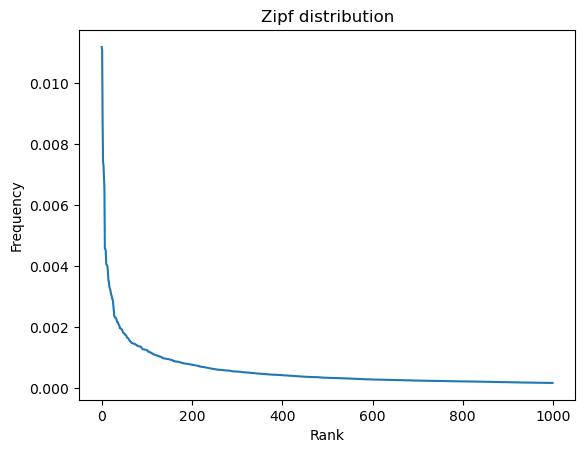

In [20]:
freqs=list(frequencies.values())
plt.plot(list(range(1000)), freqs[:1000])
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Zipf distribution")
plt.show()

In [21]:
occurences = list(counts_sorted.values())
occurence_points = [occurences[i] for i in range(0, len(occurences), 1000)]
print(occurence_points)

[9042, 130, 61, 35, 24, 17, 13, 10, 9, 7, 6, 5, 5, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Display the correlation matrix between different labels in the dataset. 

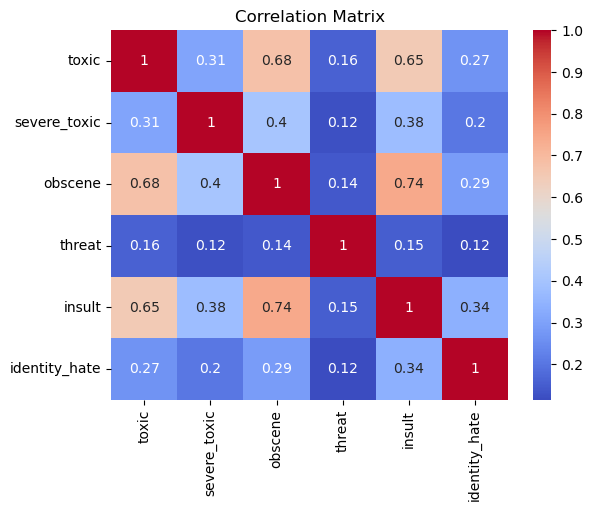

In [22]:
label_corr = data[labels].corr()

sns.heatmap(label_corr, annot=True, cmap='coolwarm') #chat5 
plt.title("Correlation Matrix")
plt.show()

#correlation - covariance normalized by the standard deviation
#note: this description does not capture one-sided dependencies

Divide the dataset into six subsets, one for each label, count most frequent words in each subset and display wordclouds for each.

In [23]:
subsets = {}
for label in labels:
    subsets[f'data_{label}'] = data[data[label] == 1]
print(subsets)

{'data_toxic':                       id                                       comment_text  \
6       0002bcb3da6cb337       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK   
12      0005c987bdfc9d4b  Hey... what is it..\n@ | talk .\nWhat is it......   
16      0007e25b2121310b  Bye! \n\nDon't look, come or think of comming ...   
42      001810bf8c45bf5f  You are gay or antisemmitian? \n\nArchangel WH...   
43      00190820581d90ce           FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!   
...                  ...                                                ...   
159494  fef4cf7ba0012866  "\n\n our previous conversation \n\nyou fuckin...   
159514  ff39a2895fc3b40e                  YOU ARE A MISCHIEVIOUS PUBIC HAIR   
159541  ffa33d3122b599d6  Your absurd edits \n\nYour absurd edits on gre...   
159546  ffb47123b2d82762  "\n\nHey listen don't you ever!!!! Delete my e...   
159554  ffbdbb0483ed0841  and i'm going to keep posting the stuff u dele...   

        toxic  severe_toxic  obscene

In [24]:
'''
for each label in the dataset, shows the wordclouds of frequent words from comments with that label
not displayed because of the presence of inappropriate language

for name, data in subsets.items():
    print(name.upper())
    tokenized = data['comment_text'].apply(lambda x: preprocess(x))
    alltext = list(chain.from_iterable(tokenized))
    print(alltext[:20])
    print(f'Number of all words: {len(alltext)}')
    unique=set(alltext)
    print(f'Number of unique words {len(unique)}')
    counts = {}
    for word in alltext:
        counts.setdefault(word, 0)
        counts[word] += 1

    wc= WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(counts)
    plt.imshow(wc, interpolation="bilinear")
    plt.show()
'''

'\nfor each label in the dataset, shows the wordclouds of frequent words from comments with that label\nnot displayed because of the presence of inappropriate language\n\nfor name, data in subsets.items():\n    print(name.upper())\n    tokenized = data[\'comment_text\'].apply(lambda x: preprocess(x))\n    alltext = list(chain.from_iterable(tokenized))\n    print(alltext[:20])\n    print(f\'Number of all words: {len(alltext)}\')\n    unique=set(alltext)\n    print(f\'Number of unique words {len(unique)}\')\n    counts = {}\n    for word in alltext:\n        counts.setdefault(word, 0)\n        counts[word] += 1\n\n    wc= WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(counts)\n    plt.imshow(wc, interpolation="bilinear")\n    plt.show()\n'

## ppmi vs tf-idf, with T-SNE

we can use the ppmi matrix to build a weighted term document matrix and plot a TSNE grapgh which compares it to the tf-idf matrix,

The PPMI-based matrix reflects semantic relationships based on word co-occurrence.

The TF-IDF matrix reflects term importance in documents.

we will try to see if this distinction is noticiable is our dataset

### PPMI functions

we need a vocabulary for building the PPMI matrix, while building the vocabulary to avoid memory constraint we will also remove words that appear less the one time in the all corpus

In [25]:
def build_vocab(tokenized_corpus, min_freq):
    
    # Flatten 
    all_words = list(chain.from_iterable(tokenized_corpus))
    
    # Count word frequencies
    counts = {}
    for word in all_words:
        counts[word] = counts.get(word, 0) + 1
    
    # Select words that appear more than min_freq times
    list_vocab = [word for word, freq in counts.items() if freq >= min_freq]
    
    # Create word to index mapping
    ids = {word: idx for idx, word in enumerate(list_vocab)}
    
    return list_vocab, ids

below there are 3 different function, each one of them computes a specific step of the pmi matrix construction, we start from row count, then we build a matrix which we use to weight the counts

In [26]:
#row count

def co_occurrence_count(comments, window_size):

    pair_counts = Counter()       #counter stores elemets as keys and their count as value

    for comment in comments:

        set_pairs = set()

        for i in range(len(comment)):
            center_word = comment[i]
            start = max(0, i - window_size )
            end = min(len(comment), i + window_size + 1)


            for j in range(start, end):
                if i != j:


                    context_word = comment[j]
                    pair = (center_word, context_word)
                    set_pairs.add(pair)

        for pair in set_pairs:
            pair_counts[pair] += 1


    return pair_counts

In [27]:
#row_count matrix

def co_occurrence_matrix(co_occurrence_count, vocab, ids):  #it takes set of pairs, a list of unique words and the index of each word as input

    cooc_matrix = dok_matrix((len(vocab),len(vocab)), dtype=np.float32) #matrix of zeros, sparse matriz using scipy

    for (word1, word2), count in co_occurrence_count.items():   #co_occurrence_count is a counter sow e can use item
        i = ids[word1]
        j = ids[word2]
        cooc_matrix[i, j] += count



    return cooc_matrix  #for efficent computation,

    #NOTE: not using sparse matrix is not possible

In [28]:
#weighted matrix

def pmi(cooc_matrix):

    total = cooc_matrix.sum()
    print(total)
    row_totals = np.array(cooc_matrix.sum(axis=1)).flatten()    #list of all rows and columns sums, flatten makes the array in a list
    col_totals = np.array(cooc_matrix.sum(axis=0)).flatten()


    expected = np.outer(row_totals, col_totals) / (total*total)  # outer product: shape [V, V]
    expected[expected == 0] = 1e-10  # small epsilon to prevent division by zero


    pmi_matrix = csr_matrix(cooc_matrix.copy()/(expected*total))
    print(pd.DataFrame(pmi_matrix.todense()))
    pmi_matrix.data=np.log2(pmi_matrix.data)  #log only the value different then 0, efficent and avoids log(0 problem)


    return pmi_matrix.todense()


this last function wraps all the prevoius ones, and return 0 for all negative value in the matrix

In [ ]:
def ppmi(comments, vocab, ids, window_size=2):
    # Get co-occurrence counts
    pair_counts = co_occurrence_count(comments, window_size)

    # Build co-occurrence matrix
    cooc_matrix = co_occurrence_matrix(pair_counts, vocab, ids)

    # Compute PMI
    pmi_matrix = pmi(cooc_matrix)

    # Convert PMI to PPMI by zeroing negative values
    pmi_matrix[pmi_matrix < 0] = 0

    return pmi_matrix

### TSNE plot function

In [ ]:

def TSNE_plot(embedding, multilabels, n_components, perplexity, n_iter, random_state):

    # Standardize embedding
    scaler = StandardScaler()
    scaled_embedding = scaler.fit_transform(embedding)

    # Run t-SNE
    reducer = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter, random_state=random_state)
    embedding_projection = reducer.fit_transform(scaled_embedding)

    # Compute label count (how many toxic tags per doc)
    label_counts = np.sum(multilabels, axis=1)  # assumes multilabels is binary matrix (n_docs x 6)

    if n_components == 2:
        plt.figure(figsize=(10, 7))
        scatter = plt.scatter(embedding_projection[:, 0], embedding_projection[:, 1],
                            c=label_counts, cmap='viridis', alpha=0.7)
        cbar = plt.colorbar(scatter, label='Number of Toxic Labels')
        plt.title("t-SNE Projection by Toxicity Intensity (Multi-label)")
        plt.xlabel("first dimension")
        plt.ylabel("second dimension")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# we considered a 3d plot but was less informative 
    elif n_components == 3:
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(embedding_projection[:, 0], embedding_projection[:, 1], embedding_projection[:, 2],
                             c=label_counts, cmap='viridis', alpha=0.7)
        cbar = plt.colorbar(scatter, ax=ax, pad=0.1, label='Number of Toxic Labels')
        ax.set_title("t-SNE Projection by Toxicity Intensity (Multi-label)")
        ax.set_xlabel("First Dimension")
        ax.set_ylabel("Second Dimension")
        ax.set_zlabel("Third Dimension")
        plt.tight_layout()
        plt.show()

### svd function for reducing the dimensionality

In [129]:
svd = TruncatedSVD(n_components=100, random_state=42)

## computations for ppmi

we first preprocess the training set by applying the tokenization function then we create a vocabulary and a list of indexes for each word minus the rare ones in the vocabulary, for computational efficency 

In [31]:
X_train_tokenized=X_train.apply(lambda x: preprocess(x))

vocab_ppmi_train,ids_ppmi_train=build_vocab(X_train_tokenized,2) #2 is the minimum count a word has to have to be selected


In [32]:
with open('indexes\ids_ppmi_train.pkl', 'wb') as f:
    pickle.dump(ids_ppmi_train, f)

In [33]:
len(ids_ppmi_train)

26616

we filter the coprus taking out the word not in the vocabulary (i.e.) the rare ones 

In [34]:
filtered_corpus = [
    [token for token in sentence if token in vocab_ppmi_train]
    for sentence in X_train_tokenized
]

then we apply ppmi 

In [35]:
train_PPMI=ppmi(filtered_corpus,vocab_ppmi_train,ids_ppmi_train)

#the printet ouput below is not the PPMI matrix but is the PMI before log 

2457650.0
          0         1           2            3            4           5      \
0      0.540598  1.418399    1.846017     0.000000     0.000000    9.125780   
1      1.418399  0.627971    8.253409     5.123199     0.000000    0.301618   
2      1.846017  8.253409    4.063555    26.064802   202.726227    0.000000   
3      0.000000  5.123199   26.064802     0.000000  3901.031738   29.528418   
4      0.000000  0.000000  202.726227  3901.031738     0.000000  229.665451   
...         ...       ...         ...          ...          ...         ...   
26611  0.000000  0.000000    0.000000     0.000000     0.000000    0.000000   
26612  0.000000  0.000000    0.000000     0.000000     0.000000    0.000000   
26613  0.000000  0.000000    0.000000     0.000000     0.000000    0.000000   
26614  0.000000  0.000000    0.000000     0.000000     0.000000    0.000000   
26615  0.000000  0.000000    0.000000     0.000000     0.000000    0.000000   

             6         7         8       

In [36]:
df_matrix = pd.DataFrame(train_PPMI)
df_matrix

,0,1,2,3,4,5,6,7,8,9,...,26606,26607,26608,26609,26610,26611,26612,26613,26614,26615
0,0.000000,0.504263,0.884416,0.000000,0.000000,3.189948,0.000000,0.765236,1.088571,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1,0.504263,0.000000,3.044990,2.357045,0.000000,0.000000,0.000000,0.000000,0.321421,0.0,...,0.0,0.0,0.0,0.0,5.901366,0.0,0.0,0.0,0.0,0.000000
2,0.884416,3.044990,2.022742,4.704031,7.663389,0.000000,0.000000,0.456103,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3,0.000000,2.357045,4.704031,0.000000,11.929640,4.884032,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4,0.000000,0.000000,7.663389,11.929640,0.000000,7.843390,13.014529,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26611,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
26612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
26613,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
26614,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000


we reduce the dimensionality of the ppmi to create dense word embeddings 

In [39]:
ppmi_sparse = csr_matrix(train_PPMI)  # Convert dense DataFrame to sparse matrix 

ppmi_word_embeddings = svd.fit_transform(ppmi_sparse)

In [ ]:
np.save("matrixes/ppmi_truncated", ppmi_word_embeddings)

In [1149]:
ppmi_word_embeddings.shape

(26616, 100)

## build a term document matrix from ppmi

construct a document term matrix using the dimensionality reduced ppmi

In [1151]:
D = len(filtered_corpus)
V = len(ids_ppmi_train)
ids = {word: i for i, word in enumerate(ids_ppmi_train)}

dtm = np.zeros((D, V), dtype=np.float32)
for doc_idx, doc in enumerate(filtered_corpus):
    for word in doc:
        if word in ids:
            dtm[doc_idx, ids[word]] += 1


doc_embeddings = dtm.dot(ppmi_word_embeddings)




In [1152]:
doc_embeddings.shape

(25198, 100)

# T-SNE plotting 

In [ ]:
def sample_subset(embeddings: np.ndarray,  labels: pd.DataFrame,  subset_size,  random_seed = 42):    #chatGPT

    rng = np.random.default_rng(seed=random_seed)

    # Ensure subset_size does not exceed available data points
    subset_size = min(subset_size, embeddings.shape[0])

    indices = rng.choice(embeddings.shape[0], size=subset_size, replace=False)
    subset_embeddings = embeddings[indices, :]
    subset_labels = labels.iloc[indices]

    return subset_embeddings, subset_labels

In [ ]:
subset_ppmi_word_embedding,subset_label_ppmi=sample_subset(doc_embeddings,Y_train,5000)

c:\programmi_miei\anaconda\envs\toxic-comment-nlp\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


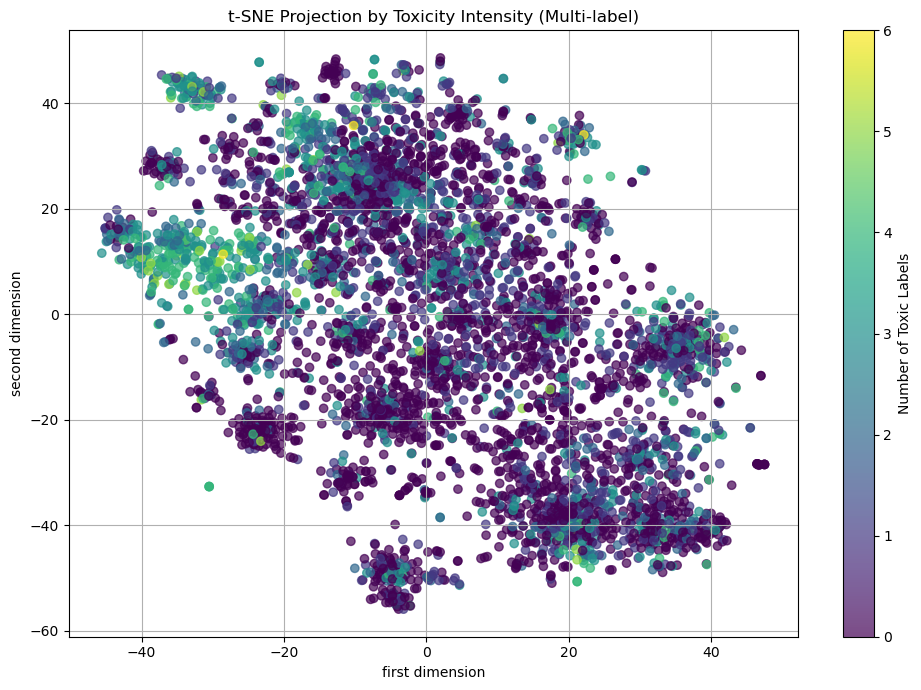

In [ ]:
TSNE_plot(subset_ppmi_word_embedding,subset_label_ppmi,2,50,3000,42)

c:\programmi_miei\anaconda\envs\toxic-comment-nlp\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


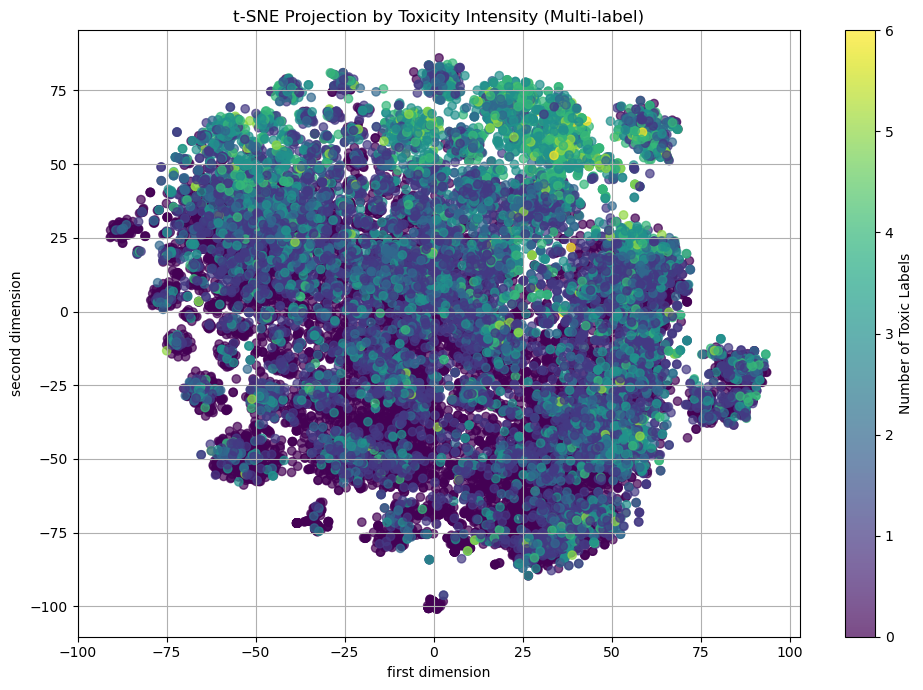

In [1170]:
TSNE_plot(doc_embeddings,Y_train,2,50,2000,42)

## tfidf computations 

In [1171]:
texts = X_train.astype(str).tolist()
vectorizer_for_Tfidf = TfidfVectorizer()
X = vectorizer_for_Tfidf.fit_transform(texts)  # returns a sparse matrix
tfidf_matrix = X.toarray()          # convert to dense if needed






In [1172]:
tfidf_dict = vectorizer_for_Tfidf.vocabulary_    #function to get the dictionary of indexes and words

In [1173]:
with open('indexes/ids_tfidf_train.pkl', 'wb') as f:
    pickle.dump(tfidf_dict, f)

we transpose the matrix since nueral networks works with sequence of words, hence we needed an embedding for each word not each document for later 

In [1174]:
tf_idf_transposed=tfidf_matrix.T

In [1175]:
tfidf_trunc_T=svd.fit_transform(tf_idf_transposed)

In [1176]:
np.save("matrixes/tfidf_trunc_T",tfidf_trunc_T)

we use the not transposed one to compute the plot of the embeddings 

In [1177]:

X_reduced_tfidf = svd.fit_transform(tfidf_matrix)

In [1182]:
np.save("matrixes/tfidf_reduced",X_reduced_tfidf)

In [298]:
X_reduced_tfidf=np.load("matrixes/tfidf_reduced.npy")

In [302]:
subset_tfidf,subset_label_tfidf=sample_subset(X_reduced_tfidf,Y_train,5000)

c:\programmi_miei\anaconda\envs\toxic-comment-nlp\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\programmi_miei\anaconda\envs\toxic-comment-nlp\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Impossibile trovare il file specificato
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\programmi_miei\anaconda\envs\toxic-comment-nlp\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\programmi_miei\anaconda\envs\toxic-comment-nlp\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^

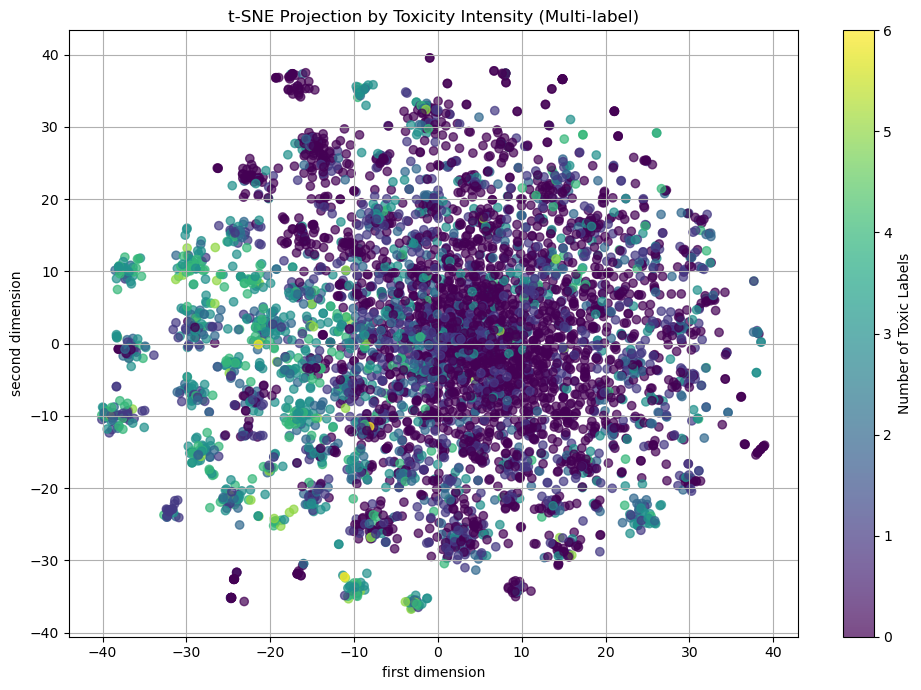

In [305]:
TSNE_plot(subset_tfidf,subset_label_tfidf,2,50,1000,42)

c:\programmi_miei\anaconda\envs\toxic-comment-nlp\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


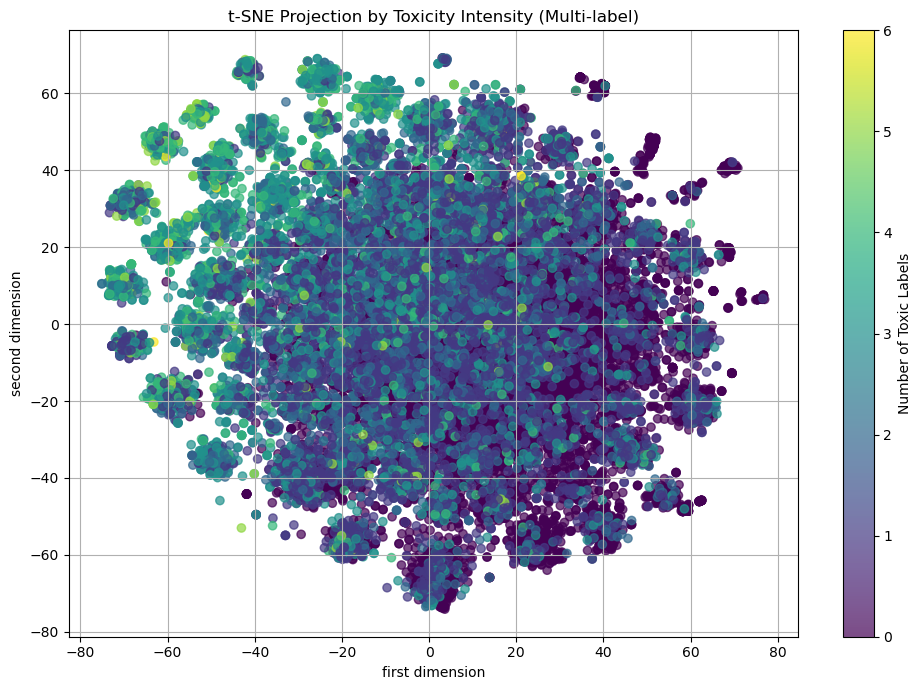

In [1178]:
TSNE_plot(X_reduced_tfidf,Y_train,2,40,1000,42)

# LSA analysis 

In [ ]:
def LSA(matrix,ids,k):
    index_to_word = {index: word for word, index in ids.items()}    
    
    for dim in range(0,5): 
        
        dim_values = matrix[:, dim]

        
        top_word_indices = np.argsort(np.abs(dim_values))[::-1][:k]

        print(f"Top {k} words for dimension {dim}:")

        for idx in top_word_indices:
            word = index_to_word.get(idx, "<unknown>")
            value = dim_values[idx]
            print(f"Word: {word}, value: {value}")

In [48]:
PPMI_Truncated =np.load("matrixes/PPMI_truncated.npy")

with open('indexes/ids_ppmi_train.pkl', 'rb') as f:
    ids_ppmi = pickle.load(f)
print(type(ids_ppmi), list(ids_ppmi.keys())[:10])


<class 'dict'> ['please', 'make', 'changes', 'contradict', 'usrd', 'guidelines', 'loop', 'considered', 'vandalism', 'may']


In [54]:
LSA(PPMI_Truncated,ids_ppmi,5)

Top 5 words for dimension 0:
Word: 's, value: 35.045536041259766
Word: one, value: 32.68697738647461
Word: also, value: 32.6560173034668
Word: ', value: 32.438236236572266
Word: people, value: 32.130943298339844
Top 5 words for dimension 1:
Word: fuck, value: 40.24942398071289
Word: fucking, value: 38.039817810058594
Word: u, value: 36.16203308105469
Word: ass, value: 35.54839324951172
Word: bitch, value: 31.80885887145996
Top 5 words for dimension 2:
Word: 's, value: -40.43645095825195
Word: like, value: -33.34630584716797
Word: ', value: -31.5064754486084
Word: one, value: -30.6159725189209
Word: also, value: -28.20682716369629
Top 5 words for dimension 3:
Word: state, value: 21.611066818237305
Word: country, value: 20.214658737182617
Word: south, value: 20.067211151123047
Word: american, value: 18.865007400512695
Word: british, value: 18.472301483154297
Top 5 words for dimension 4:
Word: anti, value: 21.822370529174805
Word: hi, value: -18.51568031311035
Word: thanks, value: -17.728

In [55]:
TFIDF_Truncated =np.load("matrixes/tfidf_reduced.npy")

with open('indexes/ids_tfidf_train.pkl', 'rb') as f:
    tfidf_ids = pickle.load(f)
print(type(tfidf_ids), list(tfidf_ids.keys())[:10])

<class 'dict'> ['please', 'do', 'not', 'make', 'changes', 'that', 'contradict', 'with', 'usrd', 'guidelines']


In [56]:
LSA(TFIDF_Truncated,tfidf_ids,5)

Top 5 words for dimension 0:
Word: 6mm, value: 0.6909195236969776
Word: calley, value: 0.6615040421540649
Word: _l, value: 0.6449194690818041
Word: babbaq, value: 0.6352114980224165
Word: eclipse, value: 0.6268150214537145
Top 5 words for dimension 1:
Word: greater, value: 0.5687743938980834
Word: earn, value: 0.5683696062990689
Word: gainesville, value: 0.568369452061588
Word: dicking, value: 0.568369452061588
Word: entertained, value: 0.568369452061588
Top 5 words for dimension 2:
Word: gibraltar, value: 0.6523873944194629
Word: foist, value: 0.6523873944194629
Word: explicate, value: 0.6385341909591729
Word: domesday, value: 0.5923893064226606
Word: dearie, value: 0.5788872384734237
Top 5 words for dimension 3:
Word: gibraltar, value: 0.4878334176050588
Word: foist, value: 0.4878334176050588
Word: explicate, value: 0.47643631501030226
Word: embalming, value: 0.47248817718932146
Word: flower, value: 0.4600578995173393
Top 5 words for dimension 4:
Word: grandfather, value: -0.31510575

# word2vec

Train word2vec embeddings. 

In [160]:
w2v = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, workers=cpu_count())
w2v.train(tokenized, total_examples=len(tokenized), epochs=10)
wv = w2v.wv

a function that represents each comment as a mean of the embeddings of it's words

In [161]:
def vectorize(comment):
  comment_vector = np.zeros(100)
  count=0
  for word in comment:
    if word in wv:
      comment_vector += wv.get_vector(word)
      count += 1
  if count: return comment_vector/count
  else: return comment_vector

# Logistic Regression classifiers

### LogReg with word2vec embeddings

In [162]:
#preparing the dataset
w2v_train_reg = tokenized.apply(lambda x: vectorize(x)).to_list()
w2v_val_reg = X_val['comment_text'].apply(lambda x: vectorize(preprocess(x))).to_list()

In [27]:
pred_train_columns = []
pred_val_columns = []
roc_auc_train = []
roc_auc_val = []

f1s_val = []

#check what 

for label in labels:
    y_train = df[label].to_list()
    y_val = Y_val[label].to_list()
    cls = LogisticRegression()
    cls.fit(w2v_train_reg, y_train)

    predicted_train = cls.predict(w2v_train_reg)
    pred_train_columns.append(predicted_train.reshape(-1,1))
    predicted_val = cls.predict(w2v_val_reg)
    pred_val_columns.append(predicted_val.reshape(-1,1))

    roc_auc_train.append(metrics.roc_auc_score(y_train, predicted_train))
    roc_auc_val.append(metrics.roc_auc_score(y_val, predicted_val))

    f1 = metrics.f1_score(y_val, predicted_val)
    f1s_val.append(f1)

    print("=====================================")
    print(label,":" "\n")
    print("Train Accuracy:", metrics.accuracy_score(y_train, predicted_train))
    print("Validation Accuracy:", metrics.accuracy_score(y_val, predicted_val))
    print("Train F1:", metrics.f1_score(y_train, predicted_train))
    print("Validation F1:", f1)

all_preds_train = np.concatenate(pred_train_columns, axis=1)
all_preds_val = np.concatenate(pred_val_columns, axis=1)

print("\n\nMean ROC AUC score (train): ", sum(roc_auc_train)/len(roc_auc_train))
print("Mean ROC AUC score (validation): ", sum(roc_auc_val)/len(roc_auc_val))
print("Mean F1: ", sum(f1s_val)/len(f1s_val))

toxic :

Train Accuracy: 0.8466544963886022
Validation Accuracy: 0.8902049257379206
Train F1: 0.8373463546051524
Validation F1: 0.5856196783349101
severe_toxic :

Train Accuracy: 0.948408603857449
Validation Accuracy: 0.989910384157423
Train F1: 0.2441860465116279
Validation F1: 0.25116279069767444
obscene :

Train Accuracy: 0.8570521469957934
Validation Accuracy: 0.9662217208748511
Train F1: 0.692399658411614
Validation F1: 0.6586447118429386
threat :

Train Accuracy: 0.985117866497341
Validation Accuracy: 0.9966785736667293
Train F1: 0.21711899791231734
Validation F1: 0.2318840579710145
insult :

Train Accuracy: 0.8307802206524327
Validation Accuracy: 0.9602682208435169
Train F1: 0.5993987222848554
Validation F1: 0.5535211267605634
identity_hate :

Train Accuracy: 0.9565044844828955
Validation Accuracy: 0.9906624052140126
Train F1: 0.20232896652110627
Validation F1: 0.2198952879581152


Mean ROC AUC score (train):  0.6746621119145996
Mean ROC AUC score (validation):  0.68959285208176

### LogReg with PPMI embeddings

In [17]:
ppmi = np.load('matrixes/ppmi_truncated.npy')
print(type(ppmi)) 

with open('indexes/ids_ppmi_train.pkl', 'rb') as f:
    ids_ppmi = pickle.load(f)

<class 'numpy.ndarray'>


In [18]:
def vec_ppmi(comment):
    comment_vector = np.zeros(100)
    count=0
    for word in comment:
        if word in ids_ppmi:
            comment_vector += ppmi[ids_ppmi[word]]
            count += 1
    if count: return comment_vector/count
    else: return comment_vector

ppmi_train_reg = tokenized.apply(lambda x: vec_ppmi(x)).to_list()
ppmi_val_reg = X_val['comment_text'].apply(lambda x: vec_ppmi(preprocess(x))).to_list()

In [19]:
pred_train_columns = []
pred_val_columns = []
roc_auc_train = []
roc_auc_val = []

f1s_val = []

#check what 

for label in labels:
    y_train = df[label].to_list()
    y_val = Y_val[label].to_list()
    cls = LogisticRegression(max_iter=1000)
    cls.fit(ppmi_train_reg, y_train)

    predicted_train = cls.predict(ppmi_train_reg)
    pred_train_columns.append(predicted_train.reshape(-1,1))
    predicted_val = cls.predict(ppmi_val_reg)
    pred_val_columns.append(predicted_val.reshape(-1,1))

    roc_auc_train.append(metrics.roc_auc_score(y_train, predicted_train))
    roc_auc_val.append(metrics.roc_auc_score(y_val, predicted_val))

    f1 = metrics.f1_score(y_val, predicted_val)
    f1s_val.append(f1)

    print("=====================================")
    print(label,":" "\n")
    print("Train Accuracy:", metrics.accuracy_score(y_train, predicted_train))
    print("Validation Accuracy:", metrics.accuracy_score(y_val, predicted_val))
    print("Train F1:", metrics.f1_score(y_train, predicted_train))
    print("Validation F1:", f1)

all_preds_train = np.concatenate(pred_train_columns, axis=1)
all_preds_val = np.concatenate(pred_val_columns, axis=1)

print("\n\nMean ROC AUC score (train): ", sum(roc_auc_train)/len(roc_auc_train))
print("Mean ROC AUC score (validation): ", sum(roc_auc_val)/len(roc_auc_val))
print("Mean F1: ", sum(f1s_val)/len(f1s_val))

toxic :

Train Accuracy: 0.8602666878323676
Validation Accuracy: 0.9048066679200351
Train F1: 0.8510386258831494
Validation F1: 0.6244746600741657
severe_toxic :

Train Accuracy: 0.9492023176442574
Validation Accuracy: 0.9900983894215705
Train F1: 0.24349881796690306
Validation F1: 0.24761904761904763
obscene :

Train Accuracy: 0.8651480276212398
Validation Accuracy: 0.9707338472143887
Train F1: 0.7106607629427794
Validation F1: 0.7012156110044786
threat :

Train Accuracy: 0.9851575521866814
Validation Accuracy: 0.9965532368239644
Train F1: 0.23360655737704916
Validation F1: 0.22535211267605634
insult :

Train Accuracy: 0.8308595920311136
Validation Accuracy: 0.9619602682208435
Train F1: 0.5983791933660009
Validation F1: 0.5585454545454546
identity_hate :

Train Accuracy: 0.9553139138026827
Validation Accuracy: 0.9909130788995425
Train F1: 0.1744868035190616
Validation F1: 0.21621621621621623


Mean ROC AUC score (train):  0.6780201729235826
Mean ROC AUC score (validation):  0.69332313

## RNN classifier

fucntion to compare different lstm results

In [34]:
def choose_threshold(y_predicted,y):
    th_f1s = {}
    for t in np.arange(0.1, 1.0, 0.1):
        y_pred_labels = (y_predicted >= t).astype(int)
        f1 = f1_score(y, y_pred_labels, average='macro')
        th_f1s[t] = f1

    best_thresh = max(th_f1s, key=th_f1s.get)
    print(f"Best threshold: {best_thresh}")
    print(f"Best macro F1: {th_f1s[best_thresh]:.4f}")
    print(th_f1s[best_thresh])



def print_roc_auc(y_predicted,y):
    val_roc_auc = [] 
     

    for i in range(6):
        val_roc_auc.append(metrics.roc_auc_score(list(y.values[:, i]), list(y_predicted[:, i])))

    print("ROC AUC scores: ", val_roc_auc)
    print("Mean ROC AUC: ", sum(val_roc_auc)/len(val_roc_auc))

### lstm subword

In [310]:
sub_train=df['comment_text'].apply(lambda x: vectorize_sub(x))
sub_train=np.stack(sub_train.values) #chat6
y_train = df[labels]
y_train=np.stack(y_train.values)

sub_val=X_val['comment_text'].apply(lambda x: vectorize_sub(x))
sub_val=np.stack(sub_val.values)
y_val=np.stack(Y_val.values)

In [1242]:
def create_model(vocab_size, output_dim, input_length, weights=None):
    model = keras.models.Sequential()
    if weights is None:
        model.add(keras.layers.Embedding(input_dim=vocab_size,
                    output_dim=output_dim,
                    input_length=input_length,
                    mask_zero=True))
    else:
        model.add(keras.layers.Embedding(input_dim = vocab_size, 
                    output_dim=output_dim, 
                    weights=[weights], 
                    input_length = input_length, 
                    trainable=False, 
                    mask_zero=True),)
    model.add(keras.layers.LSTM(units=20))
    model.add(keras.layers.Dense(40, activation='relu', kernel_initializer='he_normal'))
    model.add(keras.layers.Dense(6, activation='sigmoid'))
    print(model.summary())
    return model

In [1243]:
lstm_sub = create_model(vocab_size, 200, 200)

c:\programmi_miei\anaconda\envs\toxic-comment-nlp\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


---
here we train the model


In [ ]:
early_stopping = keras.callbacks.EarlyStopping(#CHAT
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
checkpoint = keras.callbacks.ModelCheckpoint(#CHAT
    filepath='models/lstm_sub_weighted.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

lstm_sub.compile(optimizer=keras.optimizers.Adam(learning_rate=5*10**-4),
                     loss='binary_crossentropy',
                     metrics=['binary_accuracy'])

history = lstm_sub.fit(x=sub_train,
            y=y_train,
            sample_weight=weights, #chat7
            epochs=20,
            batch_size = 64,
            validation_data = (sub_val, y_val),
            callbacks=[checkpoint, early_stopping],
            shuffle=True)


Epoch 1/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - binary_accuracy: 0.7557 - loss: 2.6886 - val_binary_accuracy: 0.9235 - val_loss: 0.2801
Epoch 2/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - binary_accuracy: 0.8992 - loss: 1.8209 - val_binary_accuracy: 0.9631 - val_loss: 0.1574
Epoch 3/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - binary_accuracy: 0.9195 - loss: 1.4404 - val_binary_accuracy: 0.9498 - val_loss: 0.1566
Epoch 4/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - binary_accuracy: 0.9294 - loss: 1.1349 - val_binary_accuracy: 0.9536 - val_loss: 0.1340
Epoch 5/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - binary_accuracy: 0.9367 - loss: 1.0021 - val_binary_accuracy: 0.9523 - val_loss: 0.1285
Epoch 6/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - binary_accuracy: 0.9435 - loss: 0.8382 - val_binary_accuracy: 0.9528 - val_loss: 0.1303
Epoch 7/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - binary_accuracy: 0.9462 - loss: 0.8175 - val_binary_accuracy: 0.9422 - val_loss:

---
load the saved model

In [212]:
lstm_sub_loaded=keras.models.load_model('models/lstm_sub_weighted.keras')


In [316]:
y_predicted_sub = lstm_sub_loaded.predict(sub_val)

499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


In [318]:
choose_threshold(y_predicted_sub, Y_val)
print_roc_auc(y_predicted_sub, Y_val)

Best threshold: 0.7000000000000001
Best macro F1: 0.5183
0.5182618042196133
ROC AUC scores:  [0.9316975585043471, 0.9676800104463505, 0.956971927164744, 0.9144221300312192, 0.9557217272437157, 0.8860678835610871]
Mean ROC AUC:  0.9354268728252438


### lstm word2vec

In [164]:
print(X_val.shape)

(15957, 1)


In [165]:
w2v_matrix = wv.vectors #chat8

def vectorize_w2v(wordlist):
    comment = []
    for word in wordlist:
        if word in w2v.wv.key_to_index and len(comment) < 100: comment.append(w2v.wv.key_to_index[word])
    if len(comment)<100: comment.extend([0]*(100-len(comment)))  
    return np.array(comment, dtype=np.int32)

w2v_train = tokenized.apply(lambda x: vectorize_w2v(x))
w2v_train = np.stack(w2v_train.values)

w2v_val = X_val['comment_text'].apply(lambda x: vectorize_w2v(preprocess(x)))
w2v_val = np.stack(w2v_val.values)



In [ ]:
lstm_w2v = create_model(vocab_size = len(w2v.wv), output_dim = 100, input_length = 100, weights=w2v_matrix)

In [1251]:
print(w2v_matrix.shape)
print(w2v_train.shape)
print(w2v_val.shape)

(18586, 100)
(25198, 100)
(15957, 100)


---
train the model

In [1252]:
early_stopping = keras.callbacks.EarlyStopping(#CHAT
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
checkpoint = keras.callbacks.ModelCheckpoint(#CHAT
    filepath='models/lstm_w2v.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

lstm_w2v.compile(optimizer=keras.optimizers.Adam(learning_rate=5*10**-4),
                     loss='binary_crossentropy',
                     metrics=['binary_accuracy'])

history = lstm_w2v.fit(x=w2v_train,
            y=y_train,
            sample_weight=weights, #chat7
            epochs=20,
            batch_size = 64,
            validation_data = (w2v_val, y_val),
            callbacks=[checkpoint, early_stopping],
            shuffle=True)

Epoch 1/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - binary_accuracy: 0.6953 - loss: 2.5762 - val_binary_accuracy: 0.9237 - val_loss: 0.2659
Epoch 2/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - binary_accuracy: 0.8798 - loss: 1.9282 - val_binary_accuracy: 0.9243 - val_loss: 0.2285
Epoch 3/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - binary_accuracy: 0.8823 - loss: 1.6842 - val_binary_accuracy: 0.9427 - val_loss: 0.1807
Epoch 4/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - binary_accuracy: 0.8906 - loss: 1.5848 - val_binary_accuracy: 0.9353 - val_loss: 0.1910
Epoch 5/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - binary_accuracy: 0.8936 - loss: 1.5396 - val_binary_accuracy: 0.9464 - val_loss: 0.1615
Epoch 6/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - binary_accuracy: 0.8951 - loss: 1.4866 - val_binary_accuracy: 0.9416 - val_loss: 0.1696
Epoch 7/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - binary_accuracy: 0.8969 - loss: 1.4350 - val_binary_accuracy: 0.9361 - val_loss: 0.1757

---
load the model and predict 

In [218]:
lstm_word2vec_loaded=keras.models.load_model('models/lstm_w2v.keras')

In [319]:
y_predicted_w2v = lstm_word2vec_loaded.predict(w2v_val)

499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [320]:

choose_threshold(y_predicted_w2v,Y_val)
print_roc_auc(y_predicted_w2v,Y_val)

Best threshold: 0.7000000000000001
Best macro F1: 0.4906
0.4905815072870983
ROC AUC scores:  [0.9388410107662541, 0.9824255279507557, 0.963079891054094, 0.9436168206675466, 0.955501395032495, 0.942947009998284]
Mean ROC AUC:  0.9544019425782383


### LSTM from ppmi

In [ ]:

with open('indexes/ids_ppmi_train.pkl', 'rb') as f:
    ids_ppmi = pickle.load(f)
print(type(ids_ppmi), list(ids_ppmi.keys())[:10])

<class 'dict'> ['please', 'make', 'changes', 'contradict', 'usrd', 'guidelines', 'loop', 'considered', 'vandalism', 'may']


In [167]:
ppmi = np.load('matrixes/ppmi_truncated.npy')
print(type(ppmi))

<class 'numpy.ndarray'>


In [168]:
print(list(ids_ppmi.items())[:10])

[('please', 0), ('make', 1), ('changes', 2), ('contradict', 3), ('usrd', 4), ('guidelines', 5), ('loop', 6), ('considered', 7), ('vandalism', 8), ('may', 9)]


In [169]:
def vectorize_ppmi(wordlist):
    comment = []
    for word in wordlist:
        if word in ids_ppmi and len(comment) < 100: comment.append(ids_ppmi[word])
    if len(comment)<100: comment.extend([0]*(100-len(comment)))  
    return np.array(comment, dtype=np.int32)

In [170]:
ppmi_train=df['comment_text'].apply(lambda x: vectorize_ppmi(preprocess(x)))
ppmi_train = np.stack(ppmi_train.values)

ppmi_val=X_val['comment_text'].apply(lambda x: vectorize_ppmi(preprocess(x)))
ppmi_val = np.stack(ppmi_val.values)

print(type(ppmi_train), ppmi_train.shape)

<class 'numpy.ndarray'> (25198, 100)


In [1259]:
lstm_ppmi = create_model(vocab_size=len(ids_ppmi), output_dim=100, input_length=100, weights=ppmi)

c:\programmi_miei\anaconda\envs\toxic-comment-nlp\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ ?                      │     2,661,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,661,600 (10.15 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,661,600 (10.15 MB)

None


---
train the model

In [1261]:
early_stopping = keras.callbacks.EarlyStopping(#CHAT
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
checkpoint = keras.callbacks.ModelCheckpoint(#CHAT 
    filepath='models/lstm_ppmi.keras', # !!!
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

In [ ]:
lstm_ppmi.compile(optimizer=keras.optimizers.Adam(learning_rate=5*10**-4),
                     loss='binary_crossentropy',
                     metrics=['binary_accuracy'])

history = lstm_ppmi.fit(x=ppmi_train,y=y_train,
            sample_weight = weights ,
            epochs=20,
            batch_size = 64,
            validation_data = (ppmi_val, y_val),
            callbacks=[checkpoint, early_stopping],
            shuffle=True)



Epoch 1/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - binary_accuracy: 0.6520 - loss: 2.6473 - val_binary_accuracy: 0.8227 - val_loss: 0.4329
Epoch 2/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - binary_accuracy: 0.8449 - loss: 2.0552 - val_binary_accuracy: 0.9024 - val_loss: 0.2965
Epoch 3/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - binary_accuracy: 0.8753 - loss: 1.8813 - val_binary_accuracy: 0.9343 - val_loss: 0.2163
Epoch 4/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - binary_accuracy: 0.8856 - loss: 1.7003 - val_binary_accuracy: 0.9354 - val_loss: 0.2014
Epoch 5/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - binary_accuracy: 0.8896 - loss: 1.6004 - val_binary_accuracy: 0.9398 - val_loss: 0.1906
Epoch 6/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - binary_accuracy: 0.8941 - loss: 1.5560 - val_binary_accuracy: 0.9465 - val_loss: 0.1730
Epoch 7/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - binary_accuracy: 0.8947 - loss: 1.5348 - val_binary_accuracy: 0.9484 - val_loss: 0.1630

---
load and predict

In [222]:
lstm_ppmi_loaded=keras.models.load_model('models/lstm_ppmi.keras')

In [321]:
y_pred_ppmi = lstm_ppmi_loaded.predict(ppmi_val)

499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [322]:

choose_threshold(y_pred_ppmi,Y_val)
print_roc_auc(y_pred_ppmi,Y_val)

Best threshold: 0.7000000000000001
Best macro F1: 0.5025
0.5024693768203339
ROC AUC scores:  [0.9360517382902912, 0.9730218218849451, 0.9618179134259071, 0.9227795587403356, 0.9531743585405221, 0.9244221858940201]
Mean ROC AUC:  0.9452112627960035


## LSTM from tf-idf

In [171]:
with open('indexes/ids_tfidf_train.pkl', 'rb') as f1:
    ids_tfidf = pickle.load(f1)
print(type(ids_tfidf), list(ids_tfidf.keys())[:10])

<class 'dict'> ['please', 'do', 'not', 'make', 'changes', 'that', 'contradict', 'with', 'usrd', 'guidelines']


In [172]:
print(len(ids_tfidf))

56116


In [173]:
def vectorize_tfidf(wordlist):
    comment = []
    for word in wordlist:
        if word in ids_tfidf and len(comment) < 100: comment.append(ids_tfidf[word])
    if len(comment)<100: comment.extend([0]*(100-len(comment)))  
    return np.array(comment, dtype=np.int32)

In [174]:
tfidf_train=df['comment_text'].apply(lambda x: vectorize_tfidf(preprocess(x)))
tfidf_train = np.stack(tfidf_train.values)

tfidf_val=X_val['comment_text'].apply(lambda x: vectorize_tfidf(preprocess(x)))
tfidf_val = np.stack(tfidf_val.values)



In [1294]:
tfidf = np.load("matrixes/tfidf_trunc_T.npy")

In [1295]:
lstm_tfidf = create_model(len(ids_tfidf), 100, 100, weights=tfidf)

c:\programmi_miei\anaconda\envs\toxic-comment-nlp\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ ?                      │     5,611,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,611,600 (21.41 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,611,600 (21.41 MB)

None


---
train the model

In [1296]:
early_stopping = keras.callbacks.EarlyStopping(#CHAT
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
checkpoint = keras.callbacks.ModelCheckpoint(#CHAT 
    filepath='models/lstm_tfidf.keras', # !!!
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

In [1297]:
lstm_tfidf.compile(optimizer=keras.optimizers.Adam(learning_rate=5*10**-4),
                     loss='binary_crossentropy',
                     metrics=['binary_accuracy'])

history = lstm_tfidf.fit(x=tfidf_train,y=y_train,
            sample_weight = weights ,
            epochs=20,
            batch_size = 64,
            validation_data = (tfidf_val, y_val),
            callbacks=[checkpoint, early_stopping],
            shuffle=True)



Epoch 1/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - binary_accuracy: 0.7120 - loss: 2.7652 - val_binary_accuracy: 0.8210 - val_loss: 0.3811
Epoch 2/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - binary_accuracy: 0.8547 - loss: 1.9653 - val_binary_accuracy: 0.9050 - val_loss: 0.3011
Epoch 3/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - binary_accuracy: 0.8831 - loss: 1.8579 - val_binary_accuracy: 0.9059 - val_loss: 0.2985
Epoch 4/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - binary_accuracy: 0.8795 - loss: 1.8198 - val_binary_accuracy: 0.9365 - val_loss: 0.2217
Epoch 5/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - binary_accuracy: 0.8847 - loss: 1.7216 - val_binary_accuracy: 0.9276 - val_loss: 0.2338
Epoch 6/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - binary_accuracy: 0.8839 - loss: 1.7618 - val_binary_accuracy: 0.9402 - val_loss: 0.1970
Epoch 7/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - binary_accuracy: 0.8836 - loss: 1.6832 - val_binary_accuracy: 0.9448 - val_loss: 0.1793

---
load the model

In [163]:
lstm_tfidf_loaded=keras.models.load_model('models/lstm_tfidf.keras')

In [323]:
y_pred_tfidf = lstm_tfidf_loaded.predict(tfidf_val)

499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [324]:

choose_threshold(y_pred_tfidf,Y_val)
print_roc_auc(y_pred_tfidf,Y_val)

Best threshold: 0.7000000000000001
Best macro F1: 0.5044
0.504393972158939
ROC AUC scores:  [0.8965953129071207, 0.9763826485479811, 0.9472547385830767, 0.890402707063088, 0.9293119319462023, 0.9295222590521952]
Mean ROC AUC:  0.9282449330166106


# bert 

In [94]:
# Check if a CUDA-capable GPU is available
print("Is CUDA available?", torch.cuda.is_available())



Is CUDA available? True


as firt thing we import the bert tokenizer, which returns a dictionary-like object containing the necessary numerical encodings of the input text for the BERT model. 

In [37]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased',do_lower_case=True)

the following function tokenize every comment individually, padding them to 128 tokens, then it creates input tensor that we will feed to bert 

In [38]:
def bert_encode(tokenizer, comments, labels, max_length=128):
    input_ids = []
    attention_masks = []
    
    for comment in comments:          #this will converte a sentence in in a tensor of ids associated to mask value  
        dict_bert = tokenizer(
            comment,
            max_length=max_length,      
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

       
        input_ids.append(dict_bert["input_ids"])   # shape [1, max_length]
        attention_masks.append(dict_bert["attention_mask"])

    # Combine all into batched tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels, dtype=torch.float32)

    return input_ids, attention_masks, labels

we create different dataset for train, val and test set, before we check if they are already series, if not we convert them

In [39]:
if isinstance(X_val, pd.DataFrame):
    X_val = X_val["comment_text"]

if isinstance(X_test, pd.DataFrame):
    X_test = X_test["comment_text"]

if isinstance(X_train,pd.DataFrame):
    X_train=X_train["comment_text"]

for computational efficency we will prepare the encoding before and then train the model, that is why we choose a padding lenght, we tried to do dyncamic padding but it reached a bottleneck in the training

In [40]:
def prepare_encodings(texts, labels):
    return bert_encode(tokenizer, texts, labels)

# Apply it to all splits
train_input_ids, train_attention_masks, train_labels         = prepare_encodings(X_train.tolist(), Y_train.values)
val_input_ids, val_attention_masks, val_labels = prepare_encodings(X_val.tolist(), Y_val.values)
test_input_ids, test_attention_masks, test_labels = prepare_encodings(X_test.tolist(), Y_test.values)

from  https://runebook.dev/en/articles/pytorch/data/torch.utils.data.TensorDataset

How it works
You create a TensorDataset by passing one or more tensors as arguments. These tensors must have the same first dimension (number of samples). Each element at index i across all the input tensors represents a single data point.

Purpose
TensorDataset's primary function is to make it easy to manage and iterate over your data when it's represented as tensors. It allows you to use PyTorch's DataLoader to efficiently load and batch your data during training.





In [41]:

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset=TensorDataset(val_input_ids,val_attention_masks,val_labels)
test_dataset=TensorDataset(test_input_ids,test_attention_masks,test_labels)

In [42]:

batch_size=32

train_dataloader=DataLoader(train_dataset, sampler=RandomSampler(train_dataset),batch_size=batch_size)   # this is non-deterministic 

val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size )

test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)



important: in the above code we use 2 different sampling: random and sequential, the randomness at training is important for 2 different purposes, 
1) avoid bias do to sample order 
2) the optimizer used, i.e. adam assumes randomness in the batch 

In [230]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=6,
    problem_type="multi_label_classification"
)

optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
# Move model to GPU if available 
device = torch.device(
    'cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)


In [ ]:
def validate(model, val_loader, device):
    model.eval()     # this ensures deterministic forward passes, we need to disable layer like dropout 
    total_loss = 0

    for batch in val_loader:
        input_ids, attention_mask, labels = [t.to(device) for t in batch]     # we assign them to either gpu or cpu, depending on the system

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    return avg_loss

the loss used by bert is automatically BCEWithLogitsLoss, this was done when we imported the model and specified the type of problem,

the loss has the following shape:
+ A sigmoid activation on the output logits (per class),
+ Followed by binary cross-entropy loss per label

In [ ]:
def train_one_epoch(model, train_loader, optimizer, device): #chat helped
    model.train()
    total_loss=0

    for batch in train_dataloader:     #we train per mini-batch for memory efficency 
       
        train_input_ids, train_attention_mask, train_labels = [t.to(device) for t in batch]
        
        optimizer.zero_grad()   # for each batch we reset the gradient 
        
        outputs = model(input_ids=train_input_ids,
                        attention_mask=train_attention_mask,
                        labels=train_labels)
        
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()    #calculates gradients of the loss w.r.t. model parameters.
        optimizer.step()    #adjusts the model parameters, uses the optimizer 
      
    avg_loss = total_loss / len(train_loader)
    return avg_loss

In [ ]:


def train_model(model, train_loader, val_loader, optimizer, device, num_epochs,output_dir):
    model.to(device)
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, device)
        val_loss = validate(model, val_loader, device)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


# save checkpoint model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print(" Saved best model and tokenizer...")

            model.eval()
            model.save_pretrained(output_dir)
            tokenizer.save_pretrained(output_dir)

In [75]:
train_model(model,train_dataloader,val_dataloader,optimizer,device,5,"models/bert_uncased")

Epoch 1/5 | Train Loss: 0.2018 | Val Loss: 0.0688
 Saved best model and tokenizer...
Epoch 2/5 | Train Loss: 0.1388 | Val Loss: 0.0585
 Saved best model and tokenizer...
Epoch 3/5 | Train Loss: 0.1165 | Val Loss: 0.0493
 Saved best model and tokenizer...
Epoch 4/5 | Train Loss: 0.0948 | Val Loss: 0.0566
Epoch 5/5 | Train Loss: 0.0734 | Val Loss: 0.0652


In [32]:
# Load the tokenizer and model from the saved directory
model_name = "models/bert_uncased"
Bert_Tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
    model_name).to(device)

In [ ]:
def predict_bert(model, dataloader, device):               # fully done by chatGPT
    model.eval()
    all_logits = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, _ = [t.to(device) for t in batch]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            all_logits.append(logits.cpu())

    y_predicted = torch.cat(all_logits, dim=0)
    y_predicted = torch.sigmoid(y_predicted).numpy()
    return y_predicted

In [43]:
y_predicted = predict_bert(model, val_dataloader, device)


choose_threshold(y_predicted, Y_val)
print_roc_auc(y_predicted, Y_val)

Best threshold: 0.4
Best macro F1: 0.6678
0.6677961662926172
ROC AUC scores:  [0.9853965102736976, 0.9844192521782472, 0.9912219138519175, 0.9770504640978901, 0.9868638279088584, 0.9925170928205638]
Mean ROC AUC:  0.9862448435218624


In [326]:
y_predicted_test = predict_bert(model, test_dataloader, device)

# Step 2: Use your existing metrics
choose_threshold(y_predicted_test, Y_test)
print_roc_auc(y_predicted_test,Y_test)

Best threshold: 0.4
Best macro F1: 0.6648
0.6647859287523588
ROC AUC scores:  [0.98441021543078, 0.9917865394353715, 0.9921699528248143, 0.9956853655981562, 0.9883912109459961, 0.9854900710565031]
Mean ROC AUC:  0.9896555592152702


# predict user input

In [175]:
# Move model to GPU if available 
device = torch.device(
    'cuda') if torch.cuda.is_available() else torch.device('cpu')

In [176]:
# Load the tokenizer and model from the saved directory
model_name = "models/bert_uncased"
Bert_Tokenizer = BertTokenizerFast.from_pretrained(model_name)
Bert_Model = BertForSequenceClassification.from_pretrained(
    model_name).to(device)

lstm_tfidf_loaded=keras.models.load_model('models/lstm_tfidf.keras')

lstm_ppmi_loaded=keras.models.load_model('models/lstm_ppmi.keras')

lstm_word2vec_loaded=keras.models.load_model('models/lstm_w2v.keras')

lstm_sub_loaded=keras.models.load_model('models/lstm_sub_weighted.keras')

In [177]:
def predict_user_input(input_text, model_type, model, tokenizer=None, vectorizer=None, device=device, threshold=None):
    
    
    labels_list = ['toxic', 'severe_toxic', 'obscene',
                    'threat', 'insult', 'identity_hate']
    
    if model_type == "bert":
        user_input = [input_text]
        user_encodings = tokenizer(
            user_input, truncation=True, padding=True, return_tensors="pt")

        user_dataset = TensorDataset(
            user_encodings['input_ids'], user_encodings['attention_mask'])

        user_loader = DataLoader(user_dataset, batch_size=1, shuffle=False)

        model.eval()
        with torch.no_grad():
            for batch in user_loader:
                input_ids, attention_mask = [t.to(device) for t in batch]
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                predictions = torch.sigmoid(logits)

        predicted_labels = (predictions.cpu().numpy() > threshold).astype(int)
        predicted_labels_1 = (predictions.cpu().numpy())

        
        
        result_clean = dict(zip(labels_list, predicted_labels[0]))
        result_prob =  dict(zip(labels_list, predicted_labels_1[0]))


    elif model_type == "lstm":
        
        
        tokens = preprocess(input_text)  # must return a list of words
        user_input = np.expand_dims(vectorizer(tokens), axis=0)  # shape: (1, 100)
        predicted_labels = model.predict(user_input,verbose=0)
        y_pred_labels = (predicted_labels >= threshold).astype(int)
        
        result_clean = dict(zip(labels_list, y_pred_labels[0]))
        result_prob = dict(zip(labels_list, predicted_labels[0]))


    elif model_type=="sub":

        user_input = np.expand_dims(vectorizer(input_text), axis=0)  # shape: (1, 100)
        predicted_labels = model.predict(user_input,verbose=0)
        y_pred_labels = (predicted_labels >= threshold).astype(int)
        
        result_clean = dict(zip(labels_list, y_pred_labels[0]))
        result_prob = dict(zip(labels_list, predicted_labels[0]))


    return result_clean,result_prob





In [ ]:
def print_prediction_results(result_clean, result_prob, precision=3):         #done by chatgpt
  
    # Combine into DataFrame for tabular formatting
    df = pd.DataFrame({
        'Label': result_clean.keys(),
        'Predicted': list(result_clean.values()),
        'Probability': [round(result_prob[k], precision) for k in result_clean.keys()]
    })

    print(df.to_string(index=False))


the choice of what comment to try is the following:

* we will try a comment which insult based on nationality to see if the model understands it as identity hate 

* we will try to see possible bias in the model by using non_toxic statement that refers to groups commonly affected by hate speech

In [337]:
text = 'freddy mmercury was a gay man '

In [338]:
print("bert")
result_clean_bert,result_prob_bert=predict_user_input(input_text=text,model_type="bert",model=Bert_Model,tokenizer=Bert_Tokenizer, threshold=0.7)
print_prediction_results(result_clean_bert, result_prob_bert)

print("-------------------------------------------------------")
print("wordtovec")

result_clean_w2v,result_prob_w2v=predict_user_input(input_text=text,model_type="lstm",model=lstm_word2vec_loaded,vectorizer=vectorize_w2v,threshold=0.7)
print_prediction_results(result_clean_w2v, result_prob_w2v)

print("-------------------------------------------------------")
print("ppmi")

result_clean_ppmi,result_prob_ppmi=predict_user_input(input_text=text,model_type="lstm",model=lstm_ppmi_loaded,vectorizer=vectorize_ppmi,threshold=0.7)
print_prediction_results(result_clean_ppmi, result_prob_ppmi)

print("-------------------------------------------------------")
print("tfidf")

result_clean_tfidf,result_prob_tfidf=predict_user_input(input_text=text,model_type="lstm",model=lstm_tfidf_loaded,vectorizer=vectorize_tfidf,threshold=0.7)
print_prediction_results(result_clean_tfidf, result_prob_tfidf)

print("-------------------------------------------------------")
print("sub")

result_clean_sub,result_prob_sub=predict_user_input(input_text=text,model_type="sub",model=lstm_sub_loaded,vectorizer=vectorize_sub,threshold=0.7)
print_prediction_results(result_clean_sub, result_prob_sub)


bert
        Label  Predicted  Probability
        toxic          0        0.692
 severe_toxic          0        0.003
      obscene          0        0.007
       threat          0        0.004
       insult          0        0.097
identity_hate          0        0.221
-------------------------------------------------------
wordtovec
        Label  Predicted  Probability
        toxic          1        0.803
 severe_toxic          0        0.035
      obscene          0        0.217
       threat          0        0.008
       insult          0        0.554
identity_hate          1        0.802
-------------------------------------------------------
ppmi
        Label  Predicted  Probability
        toxic          1        0.974
 severe_toxic          0        0.025
      obscene          0        0.179
       threat          0        0.003
       insult          0        0.588
identity_hate          1        0.967
-------------------------------------------------------
tfidf
        

the word mexican appears in wordcloud for identity

In [339]:
text = 'you mexican'

In [340]:
print("bert")
result_clean_bert,result_prob_bert=predict_user_input(input_text=text,model_type="bert",model=Bert_Model,tokenizer=Bert_Tokenizer, threshold=0.7)
print_prediction_results(result_clean_bert, result_prob_bert)

print("-------------------------------------------------------")
print("wordtovec")

result_clean_w2v,result_prob_w2v=predict_user_input(input_text=text,model_type="lstm",model=lstm_word2vec_loaded,vectorizer=vectorize_w2v,threshold=0.7)
print_prediction_results(result_clean_w2v, result_prob_w2v)

print("-------------------------------------------------------")
print("ppmi")

result_clean_ppmi,result_prob_ppmi=predict_user_input(input_text=text,model_type="lstm",model=lstm_ppmi_loaded,vectorizer=vectorize_ppmi,threshold=0.7)
print_prediction_results(result_clean_ppmi, result_prob_ppmi)

print("-------------------------------------------------------")
print("tfidf")

result_clean_tfidf,result_prob_tfidf=predict_user_input(input_text=text,model_type="lstm",model=lstm_tfidf_loaded,vectorizer=vectorize_tfidf,threshold=0.7)
print_prediction_results(result_clean_tfidf, result_prob_tfidf)

print("-------------------------------------------------------")
print("sub")

result_clean_sub,result_prob_sub=predict_user_input(input_text=text,model_type="sub",model=lstm_sub_loaded,vectorizer=vectorize_sub,threshold=0.7)
print_prediction_results(result_clean_sub, result_prob_sub)


bert
        Label  Predicted  Probability
        toxic          1        0.935
 severe_toxic          0        0.007
      obscene          0        0.122
       threat          0        0.003
       insult          0        0.536
identity_hate          0        0.423
-------------------------------------------------------
wordtovec
        Label  Predicted  Probability
        toxic          1        0.774
 severe_toxic          0        0.264
      obscene          0        0.453
       threat          0        0.299
       insult          0        0.517
identity_hate          0        0.657
-------------------------------------------------------
ppmi
        Label  Predicted  Probability
        toxic          1        0.789
 severe_toxic          0        0.110
      obscene          0        0.251
       threat          0        0.076
       insult          0        0.448
identity_hate          0        0.589
-------------------------------------------------------
tfidf
        

in the dataset we have noumerous occurrences of "monekys" so we try to understand if it used more in dicusssion context 

In [ ]:
text="the monkey likes books"

In [344]:
print("bert")
result_clean_bert,result_prob_bert=predict_user_input(input_text=text,model_type="bert",model=Bert_Model,tokenizer=Bert_Tokenizer, threshold=0.7)
print_prediction_results(result_clean_bert, result_prob_bert)

print("-------------------------------------------------------")
print("wordtovec")

result_clean_w2v,result_prob_w2v=predict_user_input(input_text=text,model_type="lstm",model=lstm_word2vec_loaded,vectorizer=vectorize_w2v,threshold=0.7)
print_prediction_results(result_clean_w2v, result_prob_w2v)

print("-------------------------------------------------------")
print("ppmi")

result_clean_ppmi,result_prob_ppmi=predict_user_input(input_text=text,model_type="lstm",model=lstm_ppmi_loaded,vectorizer=vectorize_ppmi,threshold=0.7)
print_prediction_results(result_clean_ppmi, result_prob_ppmi)

print("-------------------------------------------------------")
print("tfidf")

result_clean_tfidf,result_prob_tfidf=predict_user_input(input_text=text,model_type="lstm",model=lstm_tfidf_loaded,vectorizer=vectorize_tfidf,threshold=0.7)
print_prediction_results(result_clean_tfidf, result_prob_tfidf)

print("-------------------------------------------------------")
print("sub")

result_clean_sub,result_prob_sub=predict_user_input(input_text=text,model_type="sub",model=lstm_sub_loaded,vectorizer=vectorize_sub,threshold=0.7)
print_prediction_results(result_clean_sub, result_prob_sub)


bert
        Label  Predicted  Probability
        toxic          0        0.392
 severe_toxic          0        0.001
      obscene          0        0.011
       threat          0        0.001
       insult          0        0.039
identity_hate          0        0.002
-------------------------------------------------------
wordtovec
        Label  Predicted  Probability
        toxic          1        0.917
 severe_toxic          0        0.121
      obscene          0        0.544
       threat          0        0.081
       insult          0        0.509
identity_hate          0        0.175
-------------------------------------------------------
ppmi
        Label  Predicted  Probability
        toxic          0        0.696
 severe_toxic          0        0.017
      obscene          0        0.121
       threat          0        0.022
       insult          0        0.326
identity_hate          0        0.090
-------------------------------------------------------
tfidf
        

love apperas in both nice context and insults as we can see below 

In [345]:
text="i love you"

In [346]:
print("bert")
result_clean_bert,result_prob_bert=predict_user_input(input_text=text,model_type="bert",model=Bert_Model,tokenizer=Bert_Tokenizer, threshold=0.7)
print_prediction_results(result_clean_bert, result_prob_bert)

print("-------------------------------------------------------")
print("wordtovec")

result_clean_w2v,result_prob_w2v=predict_user_input(input_text=text,model_type="lstm",model=lstm_word2vec_loaded,vectorizer=vectorize_w2v,threshold=0.7)
print_prediction_results(result_clean_w2v, result_prob_w2v)

print("-------------------------------------------------------")
print("ppmi")

result_clean_ppmi,result_prob_ppmi=predict_user_input(input_text=text,model_type="lstm",model=lstm_ppmi_loaded,vectorizer=vectorize_ppmi,threshold=0.7)
print_prediction_results(result_clean_ppmi, result_prob_ppmi)

print("-------------------------------------------------------")
print("tfidf")

result_clean_tfidf,result_prob_tfidf=predict_user_input(input_text=text,model_type="lstm",model=lstm_tfidf_loaded,vectorizer=vectorize_tfidf,threshold=0.7)
print_prediction_results(result_clean_tfidf, result_prob_tfidf)

print("-------------------------------------------------------")
print("sub")

result_clean_sub,result_prob_sub=predict_user_input(input_text=text,model_type="sub",model=lstm_sub_loaded,vectorizer=vectorize_sub,threshold=0.7)
print_prediction_results(result_clean_sub, result_prob_sub)

bert
        Label  Predicted  Probability
        toxic          0        0.024
 severe_toxic          0        0.006
      obscene          0        0.009
       threat          0        0.021
       insult          0        0.012
identity_hate          0        0.004
-------------------------------------------------------
wordtovec
        Label  Predicted  Probability
        toxic          1        0.754
 severe_toxic          0        0.143
      obscene          0        0.270
       threat          0        0.484
       insult          0        0.393
identity_hate          0        0.435
-------------------------------------------------------
ppmi
        Label  Predicted  Probability
        toxic          0        0.443
 severe_toxic          0        0.024
      obscene          0        0.107
       threat          0        0.050
       insult          0        0.155
identity_hate          0        0.094
-------------------------------------------------------
tfidf
        

In [347]:
text="stupid european "

In [348]:
print("bert")
result_clean_bert,result_prob_bert=predict_user_input(input_text=text,model_type="bert",model=Bert_Model,tokenizer=Bert_Tokenizer, threshold=0.7)
print_prediction_results(result_clean_bert, result_prob_bert)

print("-------------------------------------------------------")
print("wordtovec")

result_clean_w2v,result_prob_w2v=predict_user_input(input_text=text,model_type="lstm",model=lstm_word2vec_loaded,vectorizer=vectorize_w2v,threshold=0.7)
print_prediction_results(result_clean_w2v, result_prob_w2v)

print("-------------------------------------------------------")
print("ppmi")

result_clean_ppmi,result_prob_ppmi=predict_user_input(input_text=text,model_type="lstm",model=lstm_ppmi_loaded,vectorizer=vectorize_ppmi,threshold=0.7)
print_prediction_results(result_clean_ppmi, result_prob_ppmi)

print("-------------------------------------------------------")
print("tfidf")

result_clean_tfidf,result_prob_tfidf=predict_user_input(input_text=text,model_type="lstm",model=lstm_tfidf_loaded,vectorizer=vectorize_tfidf,threshold=0.7)
print_prediction_results(result_clean_tfidf, result_prob_tfidf)

print("-------------------------------------------------------")
print("sub")

result_clean_sub,result_prob_sub=predict_user_input(input_text=text,model_type="sub",model=lstm_sub_loaded,vectorizer=vectorize_sub,threshold=0.7)
print_prediction_results(result_clean_sub, result_prob_sub)

bert
        Label  Predicted  Probability
        toxic          1        0.986
 severe_toxic          0        0.063
      obscene          1        0.744
       threat          0        0.009
       insult          1        0.894
identity_hate          1        0.745
-------------------------------------------------------
wordtovec
        Label  Predicted  Probability
        toxic          1        0.931
 severe_toxic          0        0.124
      obscene          0        0.610
       threat          0        0.087
       insult          1        0.703
identity_hate          1        0.793
-------------------------------------------------------
ppmi
        Label  Predicted  Probability
        toxic          1        0.971
 severe_toxic          0        0.063
      obscene          1        0.705
       threat          0        0.028
       insult          1        0.826
identity_hate          1        0.962
-------------------------------------------------------
tfidf
        